In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RidgeCV

In [77]:
es = pd.read_csv('ES.csv', parse_dates=['date'])
es = es.set_index('date').sort_index()
es_4h = es['log_ret'].resample('4h').sum().to_frame('log_ret')
es_4h['log_ret'].value_counts()
data_es = es_4h.loc[~(es_4h['log_ret'] == 0)].copy()

In [78]:
gc = pd.read_csv('GC.csv', parse_dates = ['date'])
gc = gc.set_index('date').sort_index()
gc_4h = gc['log_ret'].resample('4h').sum().to_frame('log_ret')
gc_4h['log_ret'].value_counts()
data_gc = gc_4h.loc[~(gc_4h['log_ret'] == 0)].copy()

In [144]:
df = pd.read_csv('NQ.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()
df_4h = df['log_ret'].resample('4h').sum().to_frame('log_ret')
data = df_4h.loc[~(df_4h['log_ret'] == 0)].copy()

def make_features(data):
    X = pd.DataFrame(index=data.index)

    X['gc'] = data_gc['log_ret']
    X['es'] = data_es['log_ret']

    for lag in [1, 3, 5, 10]:
        X[f'lag_{lag}'] = data['log_ret'].shift(lag)
        X[f'gc_lag_{lag}'] = X['gc'].shift(lag)
        X[f'es_lag_{lag}'] = X['es'].shift(lag)

    X['std_3']  = data['log_ret'].rolling(3).std().shift(1)
    X['rolling_std_5'] = data['log_ret'].rolling(5).std().shift(1)
    X['z_score'] = data['log_ret'].shift(1) / (X['rolling_std_5'] + 1e-8)
    X['log_ret_squared'] = (data['log_ret']**2).shift(1)
    X['sign'] = np.sign(data['log_ret']).shift(1)
    
    # roll_std = data['log_ret'].rolling(window = 20).std()
    # roll_mean = data['log_ret'].rolling(window = 20).mean()
    # X['rolling_sharpe'] = roll_mean / roll_std * np.sqrt(20)

    # downside = data['log_ret'].copy()
    # downside[data['log_ret'] > 0]
    # down_std = downside.rolling(window = 20).std()
    # X['rolling_sortino'] = roll_mean / down_std * np.sqrt(20)

    am = arch_model(data['log_ret'] * 100, vol='GARCH', p=1, q=1, dist='normal')
    res = am.fit(disp='off')
    X['garch_vol'] = res.conditional_volatility.shift(1) / 100


    X['price'] = np.exp(data['log_ret'].cumsum()).shift(1)

    X['hour'] = data.index.hour
    X['day'] = data.index.day
    X['weekday'] = data.index.weekday
    X['month'] = data.index.month

    P = 24/4  
    t = np.arange(len(X))
    X['sin_2pi_t_P'] = np.sin(2 * np.pi * t / P)
    X['cos_2pi_t_P'] = np.cos(2 * np.pi * t / P)

    X['absRet'] = np.abs(data['log_ret']).shift(1)
    X['EmaAbsRet'] = X['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    X['vol'] = X['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    vol = data['log_ret'].abs().ewm(span=20).mean().ewm(span=200).mean()
    X['nr'] = data['log_ret'].shift(1) / (vol.shift(1) + 1e-8)

    delta = X['price'].diff()
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    roll_up = gain.ewm(span=14).mean()
    roll_down = loss.ewm(span=14).mean()
    X['rsi_14'] = 100 - 100/(1 + roll_up/(roll_down+1e-8))

    X['ma20'] = X['price'].rolling(20).mean().shift(1)
    X['std20'] = X['price'].rolling(20).std().shift(1)
    X['bb_upper'] = X['ma20'] + 2*X['std20']
    X['bb_lower'] = X['ma20'] - 2*X['std20']

    ema12 = X['price'].ewm(span=12).mean()
    ema26 = X['price'].ewm(span=26).mean()
    X['macd'] = (ema12 - ema26).shift(1)
    X['macd_signal'] = X['macd'].ewm(span=9).mean()

    X['skew_10'] = data['log_ret'].rolling(10).skew()
    X['kurt_10'] = data['log_ret'].rolling(10).kurt()
    X['q90_30'] = data['log_ret'].rolling(30).quantile(0.9)

    X['lag1_x_garch']  = X['lag_1'] * X['garch_vol']
    X['es_x_gc'] = X['es_lag_1']  * X['gc_lag_1']
    regime = (X['std_3'] > X['std_3'].median()).astype(int)
    X['regime_x_sign'] = regime * X['sign']

    return X.dropna()

features = make_features(data).dropna()

# X = features.drop(columns=['nr'])
# y = features['nr'].shift(-1)

# X = X.iloc[:-1]
# y = y.iloc[:-1]

# features['y'] = features['nr'].shift(-1)   
# features = features.dropna(subset=['y'])     

X = features
y = data['log_ret'].shift(-1).reindex(X.index).fillna(0)

n = len(X)
i1 = int(0.6 * n)
i2 = int(0.8 * n)

X_tr, y_tr = X[:i1], y[:i1]
X_vl, y_vl = X[i1:i2], y[i1:i2]
X_te, y_te = X[i2:], y[i2:]

# feat_train = features.iloc[:i1]
# feat_val = features.iloc[i1:i2]
# feat_test = features.iloc[i2:]

/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/d

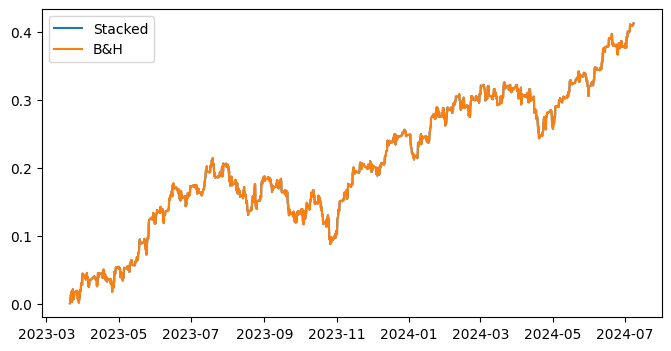

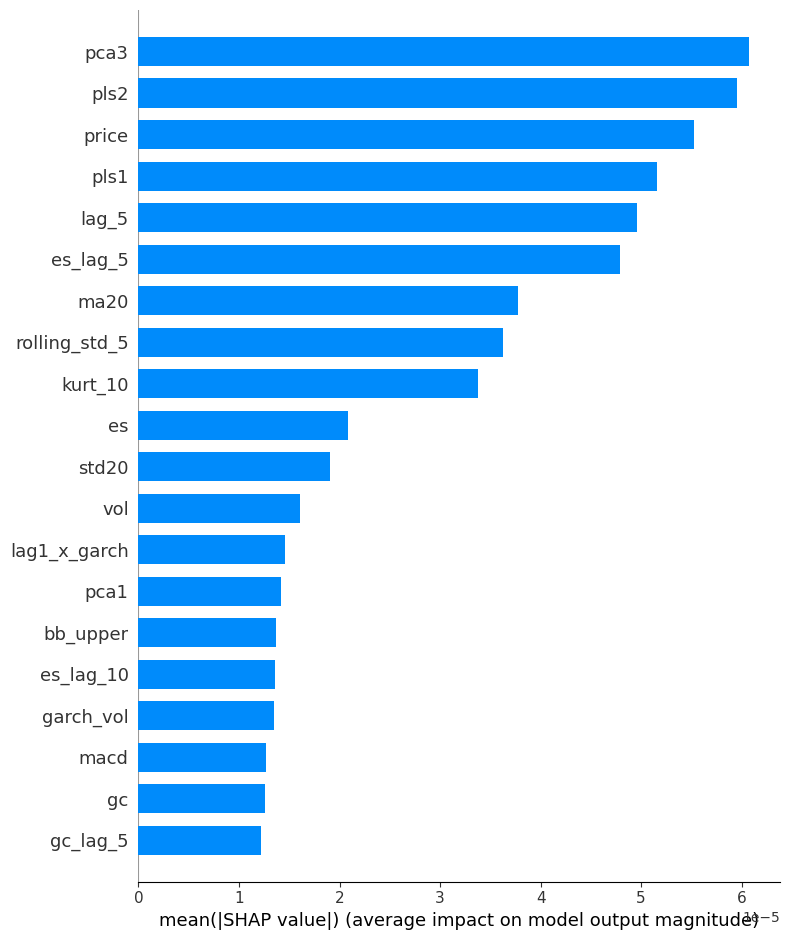

In [ ]:
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_vl)
X_te_s = scaler.transform(X_te)

# PCA / PLS
pca = PCA(n_components=3)
X_tr_pca = pca.fit_transform(X_tr_s)
X_val_pca = pca.transform(X_val_s)
X_te_pca = pca.transform(X_te_s)

pls = PLSRegression(n_components=3)
pls.fit(X_tr_s, y_tr)
X_tr_pls = pls.transform(X_tr_s)
X_val_pls = pls.transform(X_val_s)
X_te_pls = pls.transform(X_te_s)

# full features
X_tr_all = np.hstack([X_tr_s, X_tr_pca, X_tr_pls])
X_val_all = np.hstack([X_val_s, X_val_pca, X_val_pls])
X_te_all = np.hstack([X_te_s, X_te_pca, X_te_pls])

# 2) generate out‐of‐fold predictions for stacking (time-series CV)
tscv = TimeSeriesSplit(n_splits=5)
oof_cat = np.zeros(len(X_tr_all))
oof_ridge = np.zeros(len(X_tr_all))

for train_idx, test_idx in tscv.split(X_tr_all):
    X_t, X_o = X_tr_all[train_idx], X_tr_all[test_idx]
    y_t = y_tr.iloc[train_idx]
    
    # fit base models
    cb = CatBoostRegressor(iterations=200, depth=3, learning_rate=0.01, random_strength = 9.8, bagging_temperature = 0.7, l2_leaf_reg = 0.0143, loss_function='RMSE', verbose=False)
    cb.fit(X_t, y_t)
    rd = RidgeCV(alphas=[0.1,1.0,10.0]).fit(X_t, y_t)
    
    # OOF preds
    oof_cat[test_idx] = cb.predict(X_o)
    oof_ridge[test_idx] = rd.predict(X_o)

# meta‐features train
meta_X = np.column_stack([oof_cat, oof_ridge])
meta_y = y_tr.values

# fit base on full train+val, meta‐model
cat_full = CatBoostRegressor(iterations=100, depth=4, learning_rate=0.05, silent=True)
cat_full.fit(np.vstack([X_tr_all, X_val_all]), np.concatenate([y_tr, y_vl]))
ridge_full = RidgeCV(alphas=[0.1,1.0,10.0]).fit(np.vstack([X_tr_all, X_val_all]), np.concatenate([y_tr, y_val]))

# test‐level base preds
test_cat = cat_full.predict(X_te_all)
test_ridge = ridge_full.predict(X_te_all)
meta_X_test = np.column_stack([test_cat, test_ridge])

# meta model
meta = RidgeCV(alphas=[0.1,1.0,10.0]).fit(meta_X, meta_y)

# final preds & positions
pred = meta.predict(meta_X_test)
pos = np.sign(pred)  # now check dispersion

# backtest
pnl = (data['log_ret'].loc[X_te.index].values * pos).cumsum()
bh = data['log_ret'].loc[X_te.index].cumsum()

plt.figure(figsize=(8,4))
plt.plot(X_te.index, pnl, label='Stacked')
plt.plot(X_te.index, bh, label='B&H')
plt.legend()
plt.show()

# 3) SHAP for CatBoost full model
feat_names = list(X.columns) + [f'pca{i+1}' for i in range(3)] + [f'pls{i+1}' for i in range(3)]
pool = Pool(data=np.vstack([X_tr_all, X_val_all]), label=np.concatenate([y_tr,y_vl]), feature_names=feat_names)
explainer = shap.TreeExplainer(cat_full)
shap_values = explainer.shap_values(pool)

# summary plot
shap.summary_plot(shap_values, features=np.vstack([X_tr_all, X_val_all]), feature_names=feat_names, plot_type="bar")

/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.

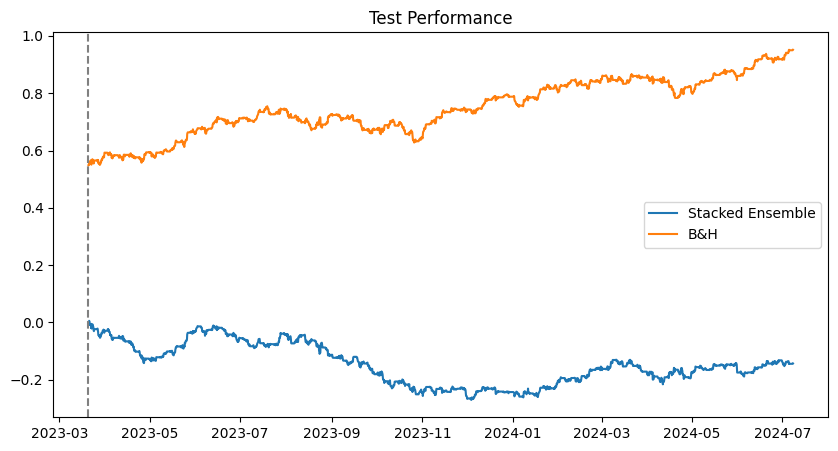

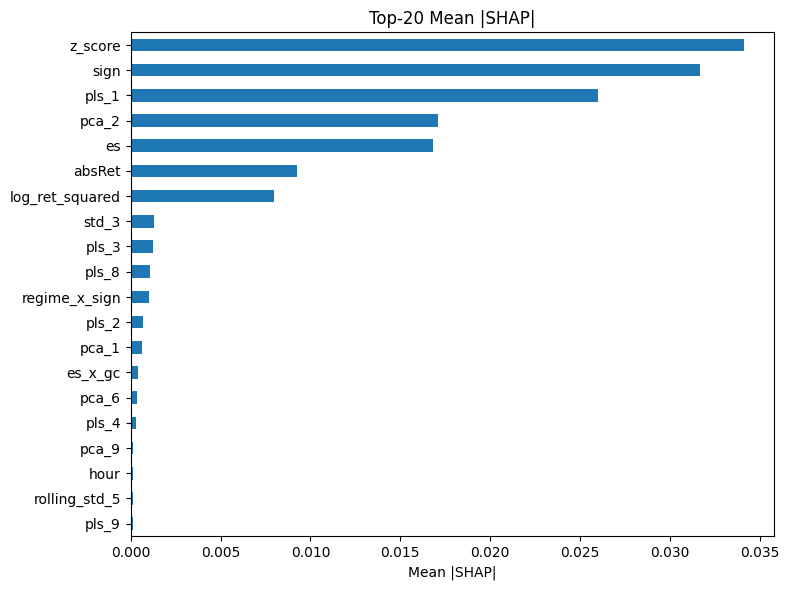

In [91]:
def add_interactions(df):
    df = df.copy()
    df['lag1_x_garch']   = df['lag_1'] * df['garch_vol']
    df['es_x_gc']        = df['es']    * df['gc']
    regime                = (df['rolling_std_5'] > df['rolling_std_5'].median()).astype(int)
    df['regime_x_sign']  = regime * df['sign']
    return df

feat_train = add_interactions(feat_train)
feat_val   = add_interactions(feat_val)
feat_test  = add_interactions(feat_test)

# 2. Масштабирование
scaler    = StandardScaler()
X_tr_s    = scaler.fit_transform(feat_train)
X_val_s   = scaler.transform(feat_val)
X_te_s    = scaler.transform(feat_test)

# 3. PCA + PLS
pca       = PCA(n_components=10)
X_tr_pca  = pca.fit_transform(X_tr_s)
X_val_pca = pca.transform(X_val_s)
X_te_pca  = pca.transform(X_te_s)

pls       = PLSRegression(n_components=10)
pls.fit(X_tr_s, y_train)
X_tr_pls  = pls.transform(X_tr_s)
X_val_pls = pls.transform(X_val_s)
X_te_pls  = pls.transform(X_te_s)

# 4. Итоговая матрица признаков
X_tr_all  = np.hstack([X_tr_s,  X_tr_pca,  X_tr_pls])
X_val_all = np.hstack([X_val_s, X_val_pca, X_val_pls])
X_te_all  = np.hstack([X_te_s,  X_te_pca,  X_te_pls])

# 5. Подгонка базовых моделей на train+val
y_trval = np.concatenate([y_train, y_val])
X_trval = np.vstack([X_tr_all, X_val_all])

cat = CatBoostRegressor(
    iterations=139, depth=3, learning_rate=0.0010939449365497188,
    l2_leaf_reg=0.014332690720221178, random_strength=9.857151142310181,
    loss_function='RMSE', logging_level='Silent'
)
cat.fit(X_trval, y_trval, verbose=False)

ridge = RidgeCV(alphas=[0.1,1.0,10.0])
ridge.fit(X_trval, y_trval)

# 6. Стекинг: готовим мета-фичи и мета-модель
pred_tr_cat   = cat.predict(X_trval)
pred_tr_ridge = ridge.predict(X_trval)
meta_X        = np.column_stack([pred_tr_cat, pred_tr_ridge])

pred_te_cat   = cat.predict(X_te_all)
pred_te_ridge = ridge.predict(X_te_all)
meta_X_test   = np.column_stack([pred_te_cat, pred_te_ridge])

meta = RidgeCV(alphas=[1.0])
meta.fit(meta_X, y_trval)

# 7. Финальные прогнозы и бэктест
preds_test = meta.predict(meta_X_test)
scale      = np.std(cat.predict(X_tr_all)) + 1e-6
raw        = preds_test / scale
pos        = np.sign(raw)
feat_test['position'] = pos

slippage = 1e-5
ret      = data['log_ret'].loc[feat_test.index]
pnl      = (ret * feat_test['position'] - slippage * feat_test['position'].diff().abs()).fillna(0)
equity   = pnl.resample('4h').sum().cumsum()
bh       = data['log_ret'].resample('4h').sum().cumsum().loc[equity.index]

plt.figure(figsize=(10,5))
plt.plot(equity, label='Stacked Ensemble')
plt.plot(bh,     label='B&H')
plt.axvline(equity.index[0], color='gray', linestyle='--')
plt.legend(); plt.title('Test Performance'); plt.show()

# 8. Важность признаков (SHAPValues из CatBoost)
raw_feats  = list(feat_train.columns)
pca_feats  = [f"pca_{i+1}"  for i in range(X_tr_pca.shape[1])]
pls_feats  = [f"pls_{i+1}"  for i in range(X_tr_pls.shape[1])]
feature_names = raw_feats + pca_feats + pls_feats

pool       = Pool(X_trval, y_trval, feature_names=feature_names)
shap_vals  = cat.get_feature_importance(pool, type='ShapValues')
shap_arr   = np.array(shap_vals)[:,:-1]  # последний столбец — base_value

mean_shap  = np.abs(shap_arr).mean(axis=0)
imp        = pd.Series(mean_shap, index=feature_names).nlargest(20)

plt.figure(figsize=(8,6))
imp[::-1].plot.barh()
plt.title('Top-20 Mean |SHAP|'); plt.xlabel('Mean |SHAP|'); plt.tight_layout(); plt.show()


Best params depth,lr: (4, 0.03) CV MSE: 2.1086890344074886e-05


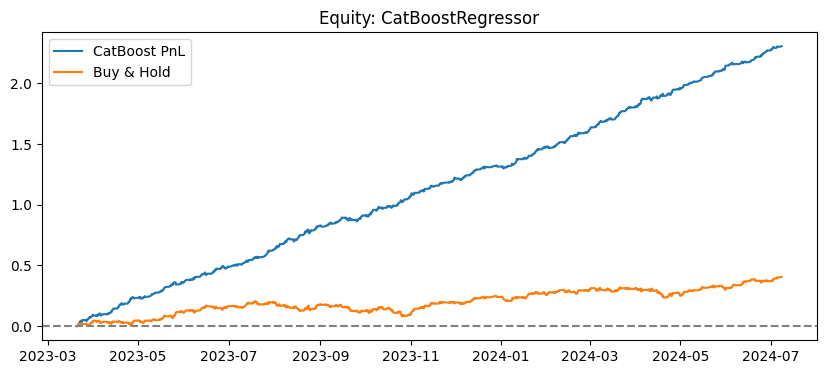

Sharpe test: 0.65


In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  

from catboost import CatBoostRegressor, Pool  
from sklearn.model_selection import TimeSeriesSplit  
from sklearn.metrics import mean_squared_error  

# 1) Загрузка + 4-часовой ресамплинг
df = pd.read_csv('NQ.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()
ret4h = df['log_ret'].resample('4h').sum()
data = ret4h.to_frame()

# 2) Функция фичей (ваши все ляги, std, z_score, garch_vol и т.д.)
def make_features(df):
    X = pd.DataFrame(index=df.index)
    X['lag1']  = df['ret'].shift(1)
    X['lag3']  = df['ret'].shift(3)
    X['lag5']  = df['ret'].shift(5)
    X['std3']  = df['ret'].rolling(3).std().shift(1)
    X['zscore']= df['ret']/ (X['std3']+1e-8)
    X['absret']= df['ret'].abs().shift(1)
    # … добавьте остальные ваши признаки analogично …
    return X

X = make_features(data).dropna()
y = data['ret'].shift(-1).loc[X.index].fillna(0)   # таргет: следующий лог-рет

# 3) Сплит по времени
n  = len(X)
i1 = int(n*0.6)
i2 = int(n*0.8)

X_tr, X_vl, X_te = X.iloc[:i1], X.iloc[i1:i2], X.iloc[i2:]  
y_tr, y_vl, y_te = y.iloc[:i1], y.iloc[i1:i2], y.iloc[i2:]  

# 4) TimeSeriesSplit + перебор гиперпараметров (кратко)
tscv = TimeSeriesSplit(n_splits=4)

best_params = None
best_mse = np.inf

for depth in [4,6,8]:
    for lr in [0.03, 0.1]:
        mses = []
        for train_idx, val_idx in tscv.split(X_tr):
            X0, X1 = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
            y0, y1 = y_tr.iloc[train_idx], y_tr.iloc[val_idx]
            
            model = CatBoostRegressor(
                iterations=200,
                depth=depth,
                learning_rate=lr,
                loss_function='RMSE',
                verbose=False
            )
            model.fit(X0, y0)
            pred = model.predict(X1)
            mses.append(mean_squared_error(y1, pred))
        
        cv_mse = np.mean(mses)
        if cv_mse < best_mse:
            best_mse, best_params = cv_mse, (depth, lr)

print("Best params depth,lr:", best_params, "CV MSE:", best_mse)

# 5) Финальный фит на Train+Val
depth, lr = best_params
model = CatBoostRegressor(
    iterations=300,
    depth=depth,
    learning_rate=lr,
    loss_function='RMSE',
    verbose=False
)
model.fit(pd.concat([X_tr,X_vl]), pd.concat([y_tr,y_vl]))

# 6) Предсказание на тесте + торговая логика
pred_te = pd.Series(model.predict(X_te), index=X_te.index)
# позиция = +1 если прогноз >0, −1 если <0
pos = np.sign(pred_te).replace({0:0})

# PnL
pnl = (data['ret'].loc[X_te.index] * pos).cumsum()
bh  = data['ret'].loc[X_te.index].cumsum()

# 7) График
plt.figure(figsize=(10,4))
plt.plot(pnl, label='CatBoost PnL')
plt.plot(bh,  label='Buy & Hold')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title('Equity: CatBoostRegressor')
plt.show()

# 8) Sharpe
rets = pnl.diff().dropna()
sr = rets.mean() / rets.std() * np.sqrt(6)  
print("Sharpe test:", sr.round(2))


In [ ]:
def objective(trial):
    # Определяем гиперпараметры для подбора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
        'loss_function': 'RMSE',
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 1.0),
        'logging_level': 'Silent'
    }
    # Обучаем модель с ранней остановкой
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True)
    
    # Делим предикты на историческое σ для сигнала
    scale = np.std(model.predict(X_train)) + 1e-6
    raw = model.predict(X_val) / scale
    
    # Генерируем позиции по порогам
    pos = np.where(raw >  0.7, 1,
           np.where(raw < 0.3, -1, 0))
    
    # Рассчитываем PnL на валидации и Sharpe ratio
    slippage = 1e-5
    ret_val = data['log_ret'].loc[feat_val.index].values
    pnl = ret_val * pos - slippage * np.abs(np.diff(np.concatenate([[0], pos])))
    daily_pnl = pd.Series(pnl, index=feat_val.index).resample('1D').sum()
    sharpe = daily_pnl.mean() / (daily_pnl.std() + 1e-9) * np.sqrt(252)
    
    return sharpe

# Создаём и запускаем исследование
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar = True)

# Лучшие параметры
best_params = study.best_params
print("Best params:", study.best_params)

[I 2025-04-23 17:29:25,152] A new study created in memory with name: no-name-34d4767d-2bc7-4b86-b330-0ec5356cef70


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_4746/2392333497.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_4746/2392333497.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_4746/2392333497.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-04-23 17:29:25,554] Trial 0 finished with value: 17.94230767605633 and parameters: {'iterations': 497, 'depth': 5, 'learning_rate': 0.04050842688068961, 'l2_leaf_reg': 0.46004581626334157, 'random_strength': 0.022759565708139518}. Best is trial 0 with value: 17.94230767605633.
[I 2025-04-23 17:29:25,924] Trial 1 finished with value: 18.02152289991782 and parameters: {'iterations': 763, 'depth': 3, 'learning_rate': 0.042599358448318615, 'l2_leaf_reg': 4.1310619982343635, 'random_strength': 0.0017668148330598184}. Best is trial 1 with value: 18.02152289991782.
[I 2025-04-23 17:29:26,335] Trial 2 finished with value: 18.383756443580133 and parameters: {'iterations': 591, 'depth': 5, 'learning_rate': 0.00463294365574445, 'l2_leaf_reg': 0.04762358694265847, 'random_strength': 0.004216443510827195}. Best is trial 2 with value: 18.383756443580133.
[I 2025-04-23 17:29:26,508] Trial 3 finished with value: 18.49861610099514 and parameters: {'iterations': 167, 'depth': 6, 'learning_rate':

0:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (0)	total: 2.41ms	remaining: 332ms
1:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (1)	total: 3.52ms	remaining: 241ms
2:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (2)	total: 4.41ms	remaining: 200ms
3:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (2)	total: 5.2ms	remaining: 175ms
4:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (4)	total: 6.04ms	remaining: 162ms
5:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (5)	total: 6.73ms	remaining: 149ms
6:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (5)	total: 7.37ms	remaining: 139ms
7:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (5)	total: 7.96ms	remaining: 130ms
8:	learn: 0.0050936	test: 0.0067317	best: 0.0067317 (5)	total: 8.64ms	remaining: 125ms
9:	learn: 0.0050935	test: 0.0067317	best: 0.0067317 (5)	total: 9.32ms	remaining: 120ms
10:	learn: 0.0050935	test: 0.0067317	best: 0.0067317 (10)	total: 9.97ms	remaining: 116ms
11:	learn: 0.0050935	test: 0.0067317	best:

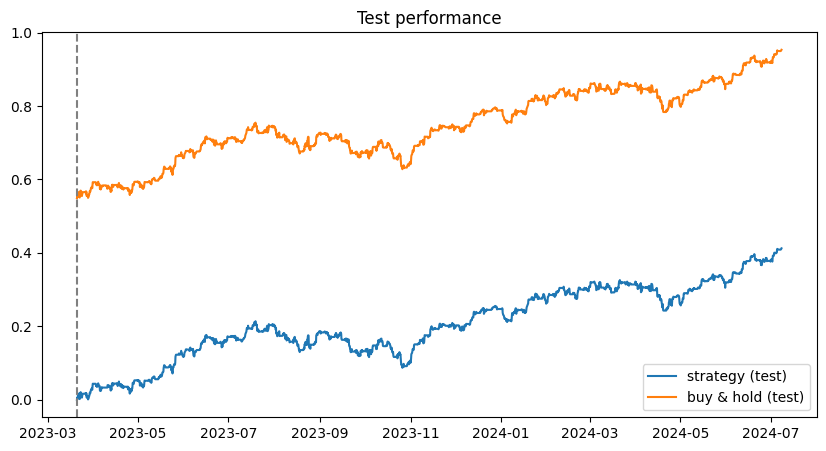

In [152]:
best_params = {
    'iterations': 139,
    'depth': 3,
    'learning_rate': 0.0010939449365497188,
    'l2_leaf_reg': 0.014332690720221178,
    'random_strength': 9.857151142310181,
    'bagging_temperature': 0.7,
    'loss_function': 'RMSE',
    #'logging_level': 'Silent'
}
model = CatBoostRegressor(**best_params)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

preds_test = model.predict(X_test)
scale = np.std(model.predict(X_train)) + 1e-6
raw = preds_test / scale

# thr = 0.7
# pos = np.where(raw > thr,  1,
#       np.where(raw < 1-thr, -1, 0))
pos = np.sign(raw)

feat_test = feat_test.copy()
feat_test['position'] = pos

slippage = 1e-5

ret_test_4h = data['log_ret'].loc[feat_test.index]

pnl = (ret_test_4h * feat_test['position'] - slippage * feat_test['position'].diff().abs()).fillna(0)

equity = pnl.resample('4h').sum().cumsum()
bh = data['log_ret'].resample('4h').sum().cumsum()

equity_test = equity.loc[feat_test.index[0]:]
bh_test = bh.loc[feat_test.index[0]:]

plt.figure(figsize=(10,5))
plt.plot(equity_test, label='strategy (test)')
plt.plot(bh_test, label='buy & hold (test)')
plt.axvline(equity.index[0], color='gray', linestyle='--')  # начало теста
plt.legend()
plt.title('Test performance')
plt.show()

In [55]:
feat['position'].value_counts()

position
 1    1117
-1     967
Name: count, dtype: int64

In [54]:
daily_vol = equity.std()
annual_vol = daily_vol * np.sqrt(252)

print(f"Daily volatility: {daily_vol:.6f}")
print(f"Annualized volatility: {annual_vol:.6f}")

daily_mean = equity.mean()
annual_return = daily_mean * 252

print(f"Daily mean return: {daily_mean:.6f}")
print(f"Annualized return: {annual_return:.6f}")

sharpe = annual_return / annual_vol
print(f"Sharpe ratio (annualized): {sharpe:.2f}")


Daily volatility: 1122.189878
Annualized volatility: 17814.212049
Daily mean return: 1912.144359
Annualized return: 481860.378465
Sharpe ratio (annualized): 27.05


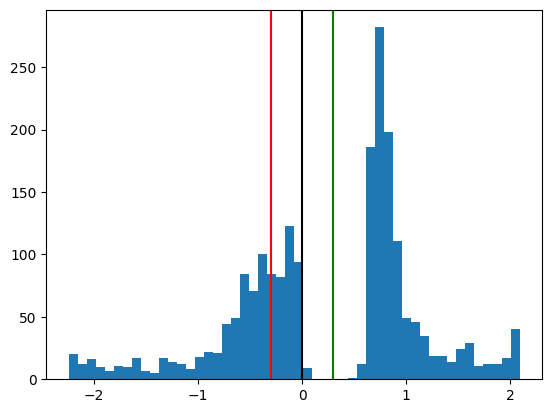

In [24]:
plt.hist(raw, bins=50)
plt.axvline(0, color='k')
plt.axvline( 0.3, color='g')
plt.axvline(-0.3, color='r')
plt.show()


0:	learn: 0.0050936	total: 9.55ms	remaining: 1.32s
1:	learn: 0.0050936	total: 12.7ms	remaining: 872ms
2:	learn: 0.0050936	total: 15.2ms	remaining: 688ms
3:	learn: 0.0050936	total: 18.1ms	remaining: 612ms
4:	learn: 0.0050936	total: 24.7ms	remaining: 663ms
5:	learn: 0.0050936	total: 26.2ms	remaining: 581ms
6:	learn: 0.0050936	total: 27.1ms	remaining: 510ms
7:	learn: 0.0050936	total: 27.7ms	remaining: 453ms
8:	learn: 0.0050936	total: 28.3ms	remaining: 408ms
9:	learn: 0.0050935	total: 28.9ms	remaining: 373ms
10:	learn: 0.0050935	total: 29.6ms	remaining: 345ms
11:	learn: 0.0050935	total: 31.1ms	remaining: 329ms
12:	learn: 0.0050935	total: 33.8ms	remaining: 328ms
13:	learn: 0.0050934	total: 36.6ms	remaining: 327ms
14:	learn: 0.0050934	total: 37.1ms	remaining: 307ms
15:	learn: 0.0050934	total: 37.7ms	remaining: 290ms
16:	learn: 0.0050933	total: 38.3ms	remaining: 275ms
17:	learn: 0.0050933	total: 38.9ms	remaining: 261ms
18:	learn: 0.0050933	total: 39.5ms	remaining: 249ms
19:	learn: 0.0050933	t

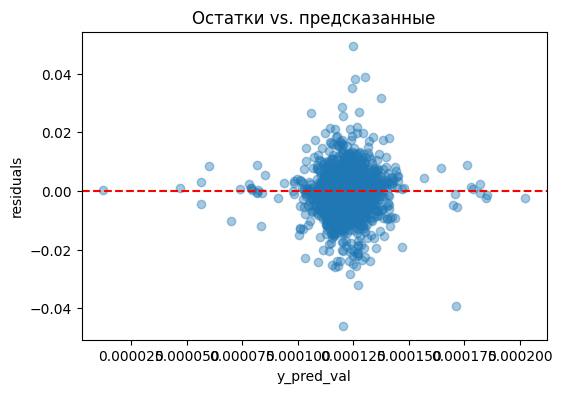

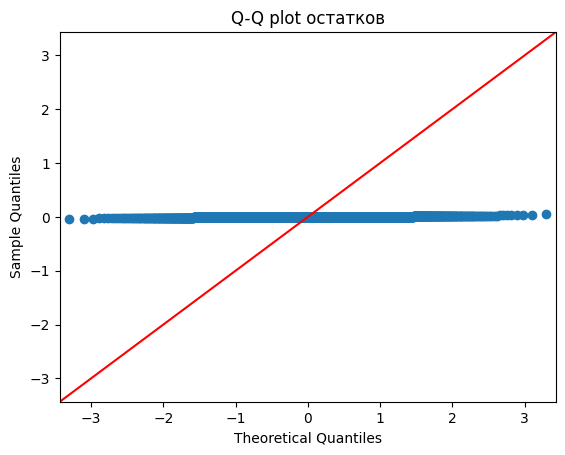

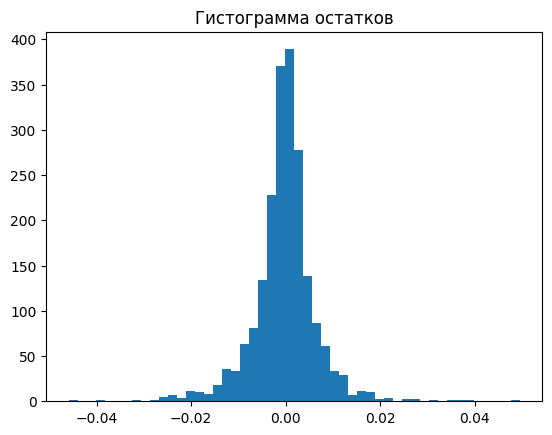

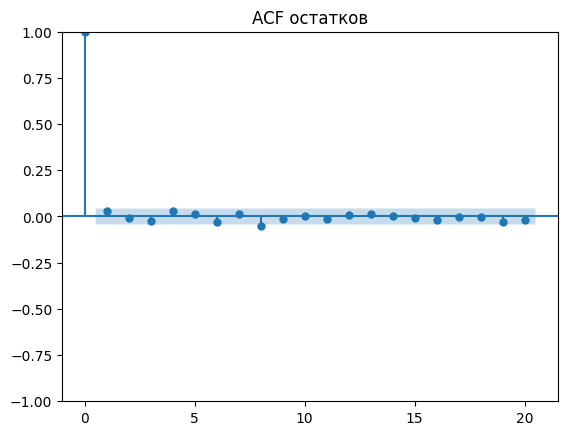

Shapiro–Wilk (нормальность): ShapiroResult(statistic=np.float64(0.9143418666167967), pvalue=np.float64(1.0710601947345246e-32))
Durbin–Watson (автокорреляция): 1.9379906799675908
Breusch–Pagan: {'Lagrange multiplier': np.float64(123.02294157968059), 'p-value': np.float64(2.098273642725763e-09)}
Ljung–Box (lag=10):
       lb_stat  lb_pvalue
10  13.989448   0.173473


/Users/ekaterinakorshik/Documents/code/venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0:	learn: 0.0039530	total: 55.3ms	remaining: 7.63s
0:	learn: 0.0040995	total: 55.4ms	remaining: 7.65s
1:	learn: 0.0039530	total: 55.7ms	remaining: 3.81s
2:	learn: 0.0039530	total: 56.5ms	remaining: 2.56s
1:	learn: 0.0040995	total: 56.4ms	remaining: 3.86s
0:	learn: 0.0043054	total: 57.5ms	remaining: 7.94s
3:	learn: 0.0039530	total: 57.4ms	remaining: 1.94s
0:	learn: 0.0054342	total: 56.3ms	remaining: 7.76s
2:	learn: 0.0040995	total: 57.9ms	remaining: 2.62s
1:	learn: 0.0043054	total: 58.2ms	remaining: 3.99s
0:	learn: 0.0053676	total: 56.9ms	remaining: 7.86s
3:	learn: 0.0040995	total: 58.7ms	remaining: 1.98s
1:	learn: 0.0054341	total: 57.4ms	remaining: 3.93s
2:	learn: 0.0043054	total: 59.3ms	remaining: 2.69s
1:	learn: 0.0053676	total: 58ms	remaining: 3.97s
4:	learn: 0.0040995	total: 59.3ms	remaining: 1.59s
4:	learn: 0.0039529	total: 59.4ms	remaining: 1.59s
5:	learn: 0.0039529	total: 60.1ms	remaining: 1.33s
2:	learn: 0.0053676	total: 59ms	remaining: 2.67s
3:	learn: 0.0043054	total: 60.5ms	r

/var/folders/7z/dntj6vfs3ydcbfxs661rp3xw0000gn/T/ipykernel_3109/3616249933.py:100: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(rets.dropna(), regression='c')


In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.sandbox.stats.runs import runstest_1samp
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Обучаем модель на train
model = CatBoostRegressor(**best_params)
model.fit(X_tr, y_tr)

# 2) Предсказания и остатки
y_pred_train = model.predict(X_tr)
y_pred_val   = model.predict(X_vl)
y_pred_test  = model.predict(X_te)

res_train = y_tr - y_pred_train
res_val   = y_vl   - y_pred_val

# 3) Основные метрики
for name, y_true, y_pred in [
    ('Train', y_tr, y_pred_train),
    ('Val',   y_vl,   y_pred_val  ),
    ('Test',  y_te,  y_pred_test )
]:
    print(f"=== {name} ===")
    print("RMSE :", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE  :", mean_absolute_error(y_true, y_pred))
    print("R2   :", r2_score(y_true, y_pred), "\n")

# 4) Диагностические графики на валидации
plt.figure(figsize=(6,4))
plt.scatter(y_pred_val, res_val, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("y_pred_val"); plt.ylabel("residuals")
plt.title("Остатки vs. предсказанные"); plt.show()

sm.qqplot(res_val, line='45')
plt.title("Q-Q plot остатков"); plt.show()

plt.hist(res_val, bins=50)
plt.title("Гистограмма остатков"); plt.show()

plot_acf(res_val, lags=20)
plt.title("ACF остатков"); plt.show()

# 5) Стат. тесты на валидации
print("Shapiro–Wilk (нормальность):", shapiro(res_val))
print("Durbin–Watson (автокорреляция):", durbin_watson(res_val))

# Гетероскедастичность
X_val_const = sm.add_constant(X_vl)
bp_test = het_breuschpagan(res_val, X_val_const)
print("Breusch–Pagan:", {
    'Lagrange multiplier': bp_test[0],
    'p-value': bp_test[1]
})

# Ljung-Box для автокорреляции
lb = acorr_ljungbox(res_val, lags=[10], return_df=True)
print("Ljung–Box (lag=10):\n", lb)

# 6) VIF для мультиколлинеарности (на train-выборке)
feat_names = feat_train.drop(columns=['nr']).columns
X_train_df = pd.DataFrame(X_tr, columns=feat_names)
X_const    = sm.add_constant(X_train_df)

vif = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

# 7) Time-series cross-validation (по осям времени)
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    CatBoostRegressor(**best_params),
    X_tr, y_tr,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
print("\nTimeSeriesSplit CV RMSE scores:", np.sqrt(-scores))
rets = data['log_ret']
print(">>> ADF test:")
adf = adfuller(rets.dropna())
print(f"ADF p-value = {adf[1]:.3f}")

print("\n>>> KPSS test:")
kpss_stat, kpss_p, _, _ = kpss(rets.dropna(), regression='c')
print(f"KPSS p-value = {kpss_p:.3f}")

print("\n>>> Engle’s ARCH test:")
arch_stat, arch_p, _, _ = het_arch(rets.dropna(), nlags=12)
print(f"ARCH p-value = {arch_p:.3f}")

print("\n>>> Runs test (рандомность):")
run_stat, run_p = runstest_1samp(rets.dropna())
print(f"Runs test p-value = {run_p:.3f}")

In [154]:
vif

,feature,VIF
0,const,103.967920
1,gc,1.015602
2,es,1.072829
3,lag_1,17.574576
4,gc_lag_1,1.039514
5,es_lag_1,7.225278
6,lag_3,6.811964
7,gc_lag_3,1.022930
8,es_lag_3,6.370238
9,lag_5,6.624298


<Axes: >

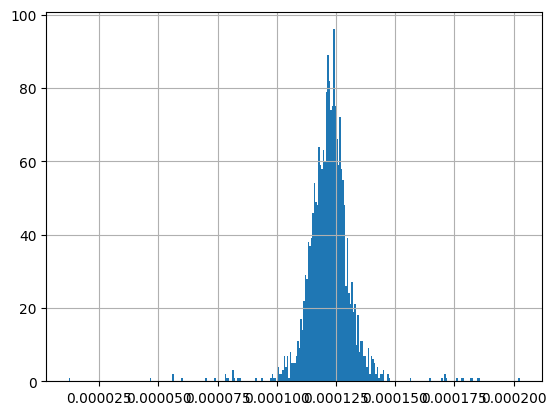

In [155]:
pd.Series(y_pred_val).hist(bins = 300)